# Particle no overlapping

Creation and testing of a function to avoid overlapping between particles when creating syntetic data. 

## Train datasets

In [1]:
import deeptrack as dt 
from numpy.random import uniform
import torch
from matplotlib import pyplot as plt
import numpy as np

class NonOverlappingPositions(dt.Feature):
    def __init__(self, min_distance, **kwargs):
        self.min_distance = min_distance
        super().__init__(**kwargs)

    def __call__(self, image, **kwargs):
        pos1, pos2 = self.generate_non_overlapping_positions(test_image_size, self.min_distance)
        self.properties["position1"] = pos1
        self.properties["position2"] = pos2
        return image

    @staticmethod
    def generate_non_overlapping_positions(size, min_distance):
        """Generate two non-overlapping positions within the given size."""
        while True:
            pos1 = uniform(size / 2 - 20, size / 2 + 20, size=2)
            pos2 = uniform(size / 2 - 20, size / 2 + 20, size=2)
            if np.linalg.norm(pos1 - pos2) > min_distance:
                return pos1, pos2

# Create the custom feature
non_overlapping_positions = NonOverlappingPositions(min_distance=15)

test_image_size = 96
test_optics = dt.Fluorescence(output_region=(0, 0, test_image_size, test_image_size), NA=2)

test_particle_C = dt.Ellipse(
    intensity = 5.0,
    position_unit="pixel",
    position = lambda: non_overlapping_positions.properties["position1"],
    radius=(5, 5)*dt.units.pixel,
)

test_particle_E = dt.Ellipse(
    intensity = 5.0,
    position_unit="pixel",
    position = lambda: non_overlapping_positions.properties["position2"],
    radius=(5, 12)*dt.units.pixel,
    rotation = lambda: np.random.uniform(0, 2 * np.pi),   
)

test_simulation_CE = (
    non_overlapping_positions
    >> test_optics(test_particle_C & test_particle_E)
    >> dt.NormalizeMinMax(0, 1)
    >> dt.Gaussian(sigma=0.1)
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

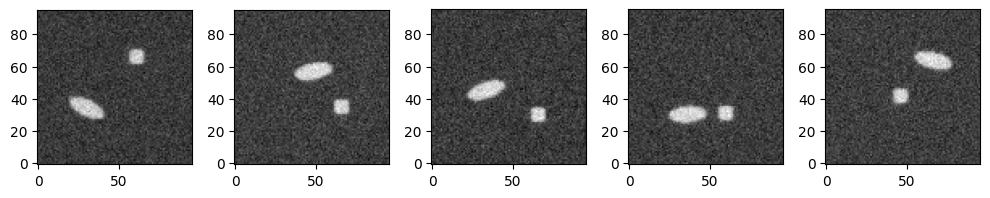

In [2]:
# Circle & Ellipse
test_dataset_CE = dt.pytorch.Dataset(test_simulation_CE & test_particle_C.position & test_particle_E.position, length=100)

plt.figure(figsize=(10, 2))
for i in range(5):
	image, *_  = test_dataset_CE[int(i)]
	plt.subplot(1, 5, i+1)
	plt.imshow(image[0], cmap="gray", origin="lower")
plt.tight_layout()
plt.show()